In [20]:
import dgl

import torch

import matplotlib.pyplot as plt

import numpy as np
from scipy import sparse as sp

In [51]:
def adjacency_matrix_n_cycle(n: int) -> np.ndarray:
    adj = np.roll(np.eye(n, dtype=np.float32), 1, axis=0) + \
        np.roll(np.eye(n, dtype=np.float32), -1, axis=0)
    return adj

def degree_matrix_n_cycle(n: int) -> np.ndarray:
    deg = 2 * np.eye(n, dtype=np.float32)

n_nodes = 256

adj = adjacency_matrix_n_cycle(n_nodes)
src, dst = np.indices((adj.shape))[:, adj != 0]



# create a graph
g = dgl.DGLGraph()
g.add_nodes(n_nodes)
g.ndata['feat'] = np.arange(n_nodes)

g.add_edges(src.flatten(), dst.flatten())
# g.edata['feat'] = edge_features

In [52]:
# Laplacian Positional Encodings from https://github.com/graphdeeplearning/benchmarking-gnns by Vijay Dwivedi

# g is a Graph object of type dgl.DGLGraph
# pos_enc_dim is an int


def positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
    """

    # Laplacian
    A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float)
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
    L = sp.eye(g.number_of_nodes()) - N * A * N

    # Eigenvectors with numpy
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort() # increasing order
    EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])
    g.ndata['pos_enc'] = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float() 

    # # Eigenvectors with scipy
    # EigVal, EigVec = sp.linalg.eigs(L, k=pos_enc_dim+1, which='SR')
    # EigVec = EigVec[:, EigVal.argsort()] # increasing order
    # g.ndata['pos_enc'] = torch.from_numpy(np.abs(EigVec[:,1:pos_enc_dim+1])).float() 
    
    return g

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


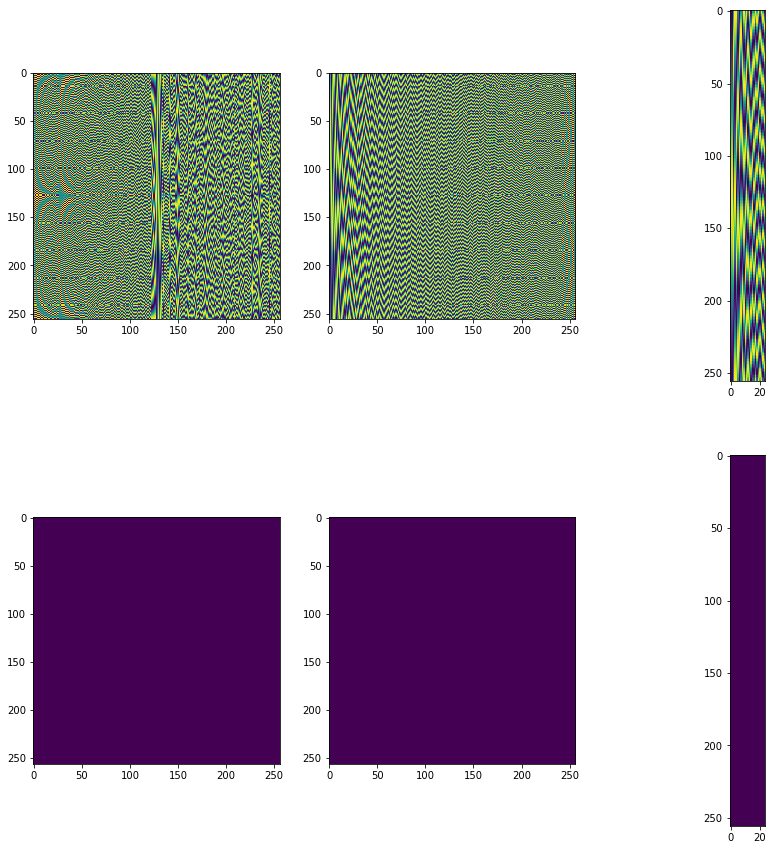

In [54]:
pos_enc_dim = 24

# Laplacian
A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float)
N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
Norm_Lap = sp.eye(g.number_of_nodes()) - N * A * N
Lap = N * N - A

A[0, -1] = 0
A[-1, 0] = 0

print(A.toarray())

# Eigenvectors with numpy
EigVal, EigVec = np.linalg.eig(Norm_Lap.toarray())

# fig, ax = plt.subplots(2, 1, figsize=(3,10))
# ax[0].imshow(np.real(EigVec[:, ::2]))
# ax[1].imshow(np.real(EigVec[:, 1::2]))

fig, axs = plt.subplots(2,3, figsize=(15,15))

axs[0, 0].imshow(np.real(EigVec))
# axs[0, 0].set_xscale('log')
# axs[0, 0].set_xlim(0.1,100)
axs[1, 0].imshow(np.imag(EigVec))

idx = EigVal.argsort() # increasing order
EigVal, EigVec = EigVal[idx], EigVec[:,idx]

axs[0, 1].imshow(np.real(EigVec))
axs[1, 1].imshow(np.imag(EigVec))

# g.ndata['pos_enc'] = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float() 

axs[0, 2].imshow(np.real(EigVec[:,1:pos_enc_dim+1]))
axs[1, 2].imshow(np.imag(EigVec[:,1:pos_enc_dim+1]))